# Transformer Encoder Block: Complete Implementation

This notebook implements and explains a complete transformer encoder block with:
- Multi-head self-attention
- Position-wise feed-forward network
- Layer normalization
- Residual connections

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Import from building blocks
import sys
sys.path.append('..')
from building_blocks import MultiHeadAttention, PositionWiseFFN, TransformerBlock, PositionalEncoding

torch.manual_seed(42)

## 1. Building Block Components

Let's review each component of a transformer block.

### 1.1 Multi-Head Attention

Multiple attention heads capture different types of relationships.

In [2]:
# Hyperparameters
batch_size = 2
seq_len = 6
d_model = 512
num_heads = 8

# Create sample input
x = torch.randn(batch_size, seq_len, d_model)

# Initialize multi-head attention
mha = MultiHeadAttention(d_model, num_heads)
attention_output = mha(x, x, x)

print("Multi-Head Attention:")
print(f"Input shape: {x.shape}")
print(f"Output shape: {attention_output.shape}")
print(f"Number of parameters: {sum(p.numel() for p in mha.parameters()):,}")

Multi-Head Attention:
Input shape: torch.Size([2, 6, 512])
Output shape: torch.Size([2, 6, 512])
Number of parameters: 1,050,624


### 1.2 Position-Wise Feed-Forward Network

Applied independently to each position.

In [3]:
# Feed-forward network
d_ff = 2048  # Typically 4 * d_model
ffn = PositionWiseFFN(d_model, d_ff)
ffn_output = ffn(x)

print("Position-Wise Feed-Forward Network:")
print(f"Input shape: {x.shape}")
print(f"Hidden dimension: {d_ff}")
print(f"Output shape: {ffn_output.shape}")
print(f"Number of parameters: {sum(p.numel() for p in ffn.parameters()):,}")

Position-Wise Feed-Forward Network:
Input shape: torch.Size([2, 6, 512])
Hidden dimension: 2048
Output shape: torch.Size([2, 6, 512])
Number of parameters: 2,099,712


### 1.3 Layer Normalization

Normalizes across the feature dimension.

In [4]:
# Layer normalization
layer_norm = nn.LayerNorm(d_model)

# Compare statistics before and after
print("Before Layer Norm:")
print(f"Mean: {x.mean():.4f}")
print(f"Std: {x.std():.4f}")

normalized = layer_norm(x)
print("\nAfter Layer Norm:")
print(f"Mean: {normalized.mean():.4f}")
print(f"Std: {normalized.std():.4f}")

Before Layer Norm:
Mean: 0.0106
Std: 1.0051

After Layer Norm:
Mean: -0.0000
Std: 1.0001


## 2. Complete Transformer Block

Combining all components with residual connections.

In [5]:
# Initialize transformer block
transformer_block = TransformerBlock(d_model, num_heads, d_ff, dropout=0.1)

print("Transformer Block Architecture:")
print(transformer_block)
print(f"\nTotal parameters: {sum(p.numel() for p in transformer_block.parameters()):,}")

Transformer Block Architecture:
TransformerBlock(
  (attention): MultiHeadAttention(
    (W_q): Linear(in_features=512, out_features=512, bias=True)
    (W_k): Linear(in_features=512, out_features=512, bias=True)
    (W_v): Linear(in_features=512, out_features=512, bias=True)
    (W_o): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ffn): PositionWiseFFN(
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

Total parameters: 3,152,384


In [6]:
# Forward pass
output = transformer_block(x)

print("Transformer Block Forward Pass:")
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"\nShape preserved: {x.shape == output.shape}")

Transformer Block Forward Pass:
Input shape: torch.Size([2, 6, 512])
Output shape: torch.Size([2, 6, 512])

Shape preserved: True


## 3. Visualizing Data Flow

Let's trace how data flows through the transformer block.

In [7]:
# Track intermediate outputs
def transformer_block_detailed(x, block):
    """
    Detailed forward pass with intermediate outputs
    """
    outputs = {}
    outputs['input'] = x.clone()
    
    # Multi-head attention
    attn_out = block.attention(x, x, x)
    outputs['attention'] = attn_out.clone()
    
    # First residual connection
    x = x + block.dropout1(attn_out)
    outputs['after_residual_1'] = x.clone()
    
    # First layer norm
    x = block.norm1(x)
    outputs['after_norm_1'] = x.clone()
    
    # Feed-forward network
    ffn_out = block.ffn(x)
    outputs['ffn'] = ffn_out.clone()
    
    # Second residual connection
    x = x + block.dropout2(ffn_out)
    outputs['after_residual_2'] = x.clone()
    
    # Second layer norm
    x = block.norm2(x)
    outputs['output'] = x.clone()
    
    return outputs

# Run detailed forward pass
sample_input = torch.randn(1, 4, d_model)
intermediates = transformer_block_detailed(sample_input, transformer_block)

# Display statistics at each stage
print("Data Flow Statistics:\n")
for name, tensor in intermediates.items():
    print(f"{name:20s} | Mean: {tensor.mean():7.4f} | Std: {tensor.std():7.4f} | Shape: {tuple(tensor.shape)}")

Data Flow Statistics:

input                | Mean:  0.0089 | Std:  0.9940 | Shape: (1, 4, 512)
attention            | Mean:  0.0057 | Std:  0.1867 | Shape: (1, 4, 512)
after_residual_1     | Mean:  0.0148 | Std:  1.0096 | Shape: (1, 4, 512)
after_norm_1         | Mean: -0.0000 | Std:  1.0002 | Shape: (1, 4, 512)
ffn                  | Mean: -0.0020 | Std:  0.2450 | Shape: (1, 4, 512)
after_residual_2     | Mean: -0.0027 | Std:  1.0270 | Shape: (1, 4, 512)
output               | Mean:  0.0000 | Std:  1.0002 | Shape: (1, 4, 512)


## 4. Effect of Residual Connections

Residual connections help with gradient flow and training stability.

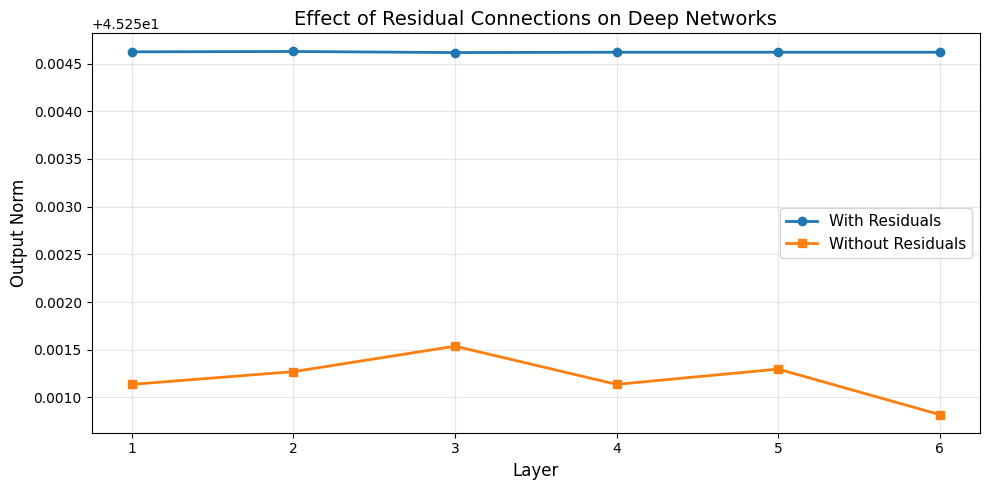

Final norm with residuals: 45.2546
Final norm without residuals: 45.2508


In [8]:
# Compare with and without residuals
class TransformerBlockNoResidual(nn.Module):
    """Transformer block WITHOUT residual connections"""
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.ffn = PositionWiseFFN(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
    def forward(self, x, mask=None):
        # No residual connections!
        x = self.norm1(self.attention(x, x, x, mask))
        x = self.norm2(self.ffn(x))
        return x

# Stack multiple blocks
num_layers = 6
input_tensor = torch.randn(1, 4, d_model)

# With residuals
blocks_with = nn.ModuleList([TransformerBlock(d_model, num_heads, d_ff) for _ in range(num_layers)])
x_with = input_tensor.clone()
norms_with = []
for block in blocks_with:
    x_with = block(x_with)
    norms_with.append(x_with.norm().item())

# Without residuals
blocks_without = nn.ModuleList([TransformerBlockNoResidual(d_model, num_heads, d_ff) for _ in range(num_layers)])
x_without = input_tensor.clone()
norms_without = []
for block in blocks_without:
    x_without = block(x_without)
    norms_without.append(x_without.norm().item())

# Plot comparison
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_layers + 1), norms_with, marker='o', label='With Residuals', linewidth=2)
plt.plot(range(1, num_layers + 1), norms_without, marker='s', label='Without Residuals', linewidth=2)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Output Norm', fontsize=12)
plt.title('Effect of Residual Connections on Deep Networks', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final norm with residuals: {norms_with[-1]:.4f}")
print(f"Final norm without residuals: {norms_without[-1]:.4f}")

## 5. Positional Encoding

Since attention has no notion of position, we add positional information.

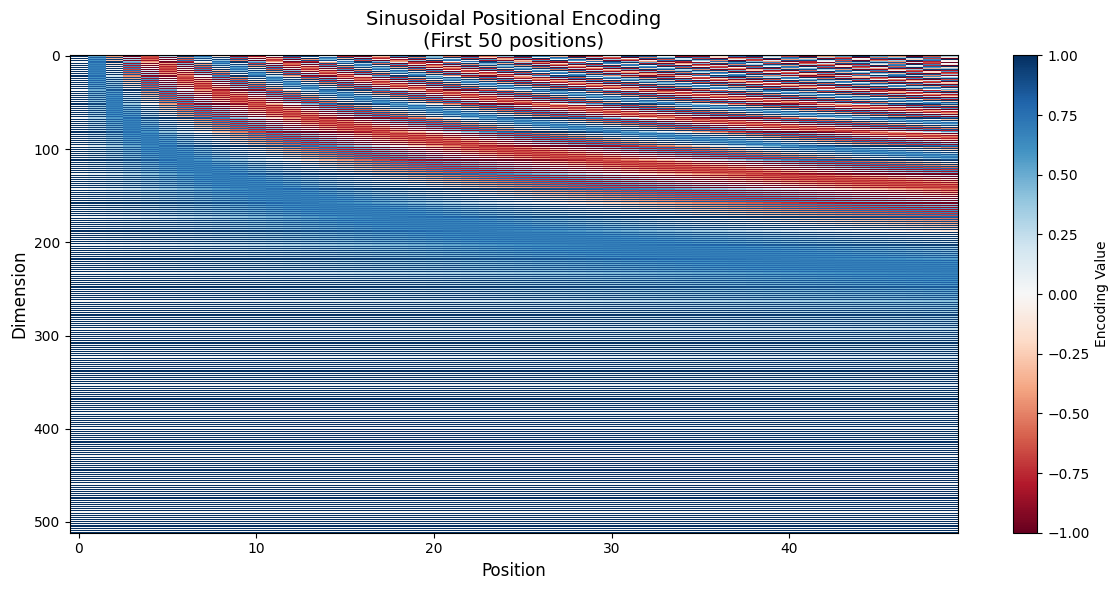

In [9]:
# Create positional encoding
pos_encoding = PositionalEncoding(d_model, max_len=100)

# Visualize positional encoding
pe_matrix = pos_encoding.pe.squeeze(0)[:50, :].numpy()

plt.figure(figsize=(12, 6))
plt.imshow(pe_matrix.T, cmap='RdBu', aspect='auto', interpolation='nearest')
plt.colorbar(label='Encoding Value')
plt.xlabel('Position', fontsize=12)
plt.ylabel('Dimension', fontsize=12)
plt.title('Sinusoidal Positional Encoding\n(First 50 positions)', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Apply positional encoding to embeddings
embeddings = torch.randn(batch_size, seq_len, d_model)
embeddings_with_pos = pos_encoding(embeddings)

print("Positional Encoding:")
print(f"Input embeddings shape: {embeddings.shape}")
print(f"Output shape: {embeddings_with_pos.shape}")
print(f"\nPositional encoding added to each position")

## 6. Complete Transformer Encoder

Stack multiple transformer blocks to create a full encoder.

In [10]:
class TransformerEncoder(nn.Module):
    """
    Complete Transformer Encoder
    """
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, dropout=0.1, max_len=5000):
        super().__init__()
        
        # Token embeddings
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)
        
        # Stack of transformer blocks
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        self.d_model = d_model
        
    def forward(self, x, mask=None):
        """
        Args:
            x: Input token indices (batch, seq_len)
            mask: Optional attention mask
        """
        # Embed tokens and add positional encoding
        x = self.embedding(x) * math.sqrt(self.d_model)  # Scale by sqrt(d_model)
        x = self.pos_encoding(x)
        
        # Pass through transformer blocks
        for layer in self.layers:
            x = layer(x, mask)
        
        return x

# Initialize encoder
vocab_size = 10000
num_layers = 6
encoder = TransformerEncoder(vocab_size, d_model, num_heads, d_ff, num_layers)

print("Complete Transformer Encoder:")
print(f"Vocabulary size: {vocab_size:,}")
print(f"Model dimension: {d_model}")
print(f"Number of layers: {num_layers}")
print(f"Number of heads: {num_heads}")
print(f"Total parameters: {sum(p.numel() for p in encoder.parameters()):,}")

Complete Transformer Encoder:
Vocabulary size: 10,000
Model dimension: 512
Number of layers: 6
Number of heads: 8
Total parameters: 24,034,304


In [11]:
# Test the encoder
sample_tokens = torch.randint(0, vocab_size, (batch_size, seq_len))
encoder_output = encoder(sample_tokens)

print("\nEncoder Forward Pass:")
print(f"Input tokens shape: {sample_tokens.shape}")
print(f"Output embeddings shape: {encoder_output.shape}")
print(f"\nEach token now has a contextualized representation!")


Encoder Forward Pass:
Input tokens shape: torch.Size([2, 6])
Output embeddings shape: torch.Size([2, 6, 512])

Each token now has a contextualized representation!


## 7. Attention Pattern Analysis

Let's visualize what the attention heads are learning.

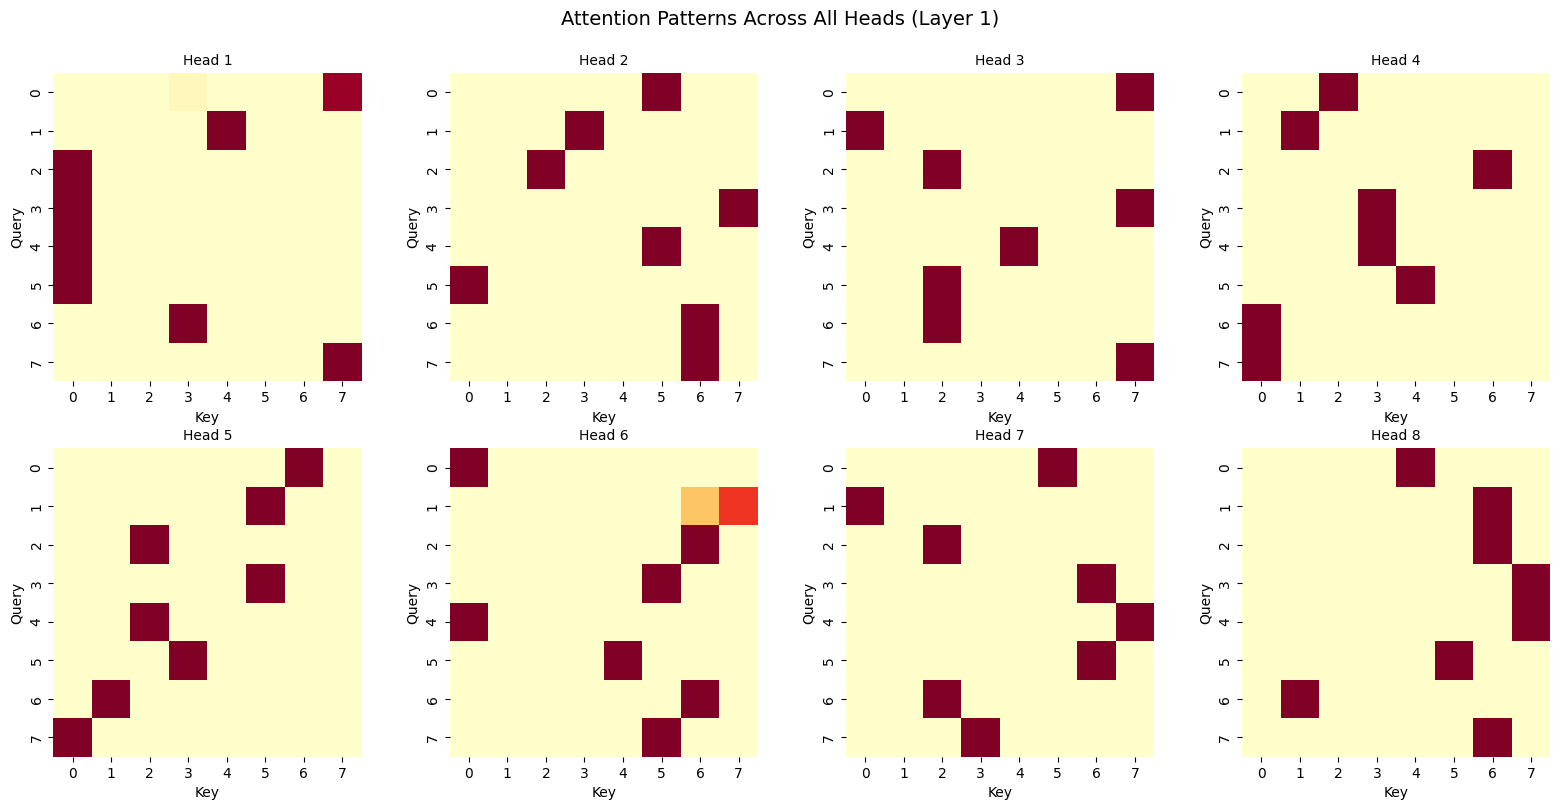

In [12]:
# Extract attention weights from a specific layer
def get_attention_weights(model, x, layer_idx=0):
    """
    Extract attention weights from a specific layer
    """
    # Embed and add positional encoding
    x = model.embedding(x) * math.sqrt(model.d_model)
    x = model.pos_encoding(x)
    
    # Get to specified layer
    for i, layer in enumerate(model.layers):
        if i == layer_idx:
            # Extract attention weights
            Q = layer.attention.W_q(x)
            K = layer.attention.W_k(x)
            
            batch_size = x.size(0)
            Q = Q.view(batch_size, -1, layer.attention.num_heads, layer.attention.d_k).transpose(1, 2)
            K = K.view(batch_size, -1, layer.attention.num_heads, layer.attention.d_k).transpose(1, 2)
            
            scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(layer.attention.d_k)
            attention_weights = F.softmax(scores, dim=-1)
            
            return attention_weights
        x = layer(x)
    
    return None

# Get attention weights
sample_input = torch.randint(0, vocab_size, (1, 8))
attn_weights = get_attention_weights(encoder, sample_input, layer_idx=0)

# Visualize all heads
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for head_idx in range(num_heads):
    attn = attn_weights[0, head_idx].detach().numpy()
    sns.heatmap(attn, ax=axes[head_idx], cmap='YlOrRd', cbar=False, square=True)
    axes[head_idx].set_title(f'Head {head_idx + 1}', fontsize=10)
    axes[head_idx].set_xlabel('Key')
    axes[head_idx].set_ylabel('Query')

plt.suptitle('Attention Patterns Across All Heads (Layer 1)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

## Summary

### Key Components of Transformer Block:

1. **Multi-Head Attention**: Captures different types of relationships
2. **Feed-Forward Network**: Processes each position independently
3. **Layer Normalization**: Stabilizes training
4. **Residual Connections**: Enables deep networks
5. **Positional Encoding**: Adds sequence order information

### Why This Architecture Works:

- **Parallel Processing**: All positions computed simultaneously
- **Long-Range Dependencies**: Direct connections between any two positions
- **Flexible Attention**: Can learn various linguistic patterns
- **Stable Training**: Residuals and normalization enable deep stacking

This forms the foundation for models like BERT and GPT!